```matlab
close all; clear; clc;

load_file = true;
if load_file && isfile('integ.mat')
    clear load_file; load('integ.mat');
else
    lin = linspace(-1+1e-5, 1-1e-5, 101);
    [rho, m_s] = meshgrid(lin, lin.*10);
    out = normcdf(m_s)-fun(rho, m_s)./sqrt(pi);
    clear lin load_file; save('integ.mat');
end
com = approximation(rho, m_s);

figure; surf(rho, m_s, out);
figure; surf(rho, m_s, com);
figure; surf(rho, m_s, out-com);

function z = fun(x, y)
    I = @(a, b, c) integral(@(x) erf(a.*x+b)./exp(x.^2), c, Inf);
    ix = sqrt(1-x.^2);
    iy = sqrt(0.5)*y;
    z = arrayfun(I, x./ix, iy./ix, -iy);
end

function z = approximation(x, y)
    s = (x+1)./2;
    b = erf(2*s.^sqrt(1/pi)).*sqrt(1/2)+(2-sqrt(2)/2);
    d = s.^(1/(2/sqrt(pi)+1)).*(sqrt(2)-sqrt(pi)/2)+sqrt(pi)/2;
    z = acos(x).*exp(-abs(y./d).^b)/pi;
end
```

In [0]:
#@title Initialization { run: "auto", display-mode: "form" }
import math
import builtins
from itertools import product
from argparse import Namespace

import torch
from torch import nn
from torch.nn import functional as F

from tqdm import tqdm
from scipy.io import loadmat
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


class Expression:
    def __init__(self, out=None, **units):
        self.out = out
        self.terms = {}
        self.coeffs = {}
        terms = self.generate_terms(**units)
        for key, value in terms.items():
            self[key] = value

    @staticmethod
    def generate_terms(**units):
        terms = {}
        for term in product(*[(None, k) for k in units]):
            key = tuple(t for t in term if t is not None)
            value = units[key[-1]] if key else torch.zeros(())
            if len(key) > 1:
                value = value * terms[key[:-1]]
            terms[key] = value
        if torch.is_tensor(value):  # same device and dtype
            terms[()] = value.new_zeros(())
        return terms

    def __getitem__(self, key):
        if isinstance(key, str):
            return (key,)
        return tuple(sorted(key))

    def __setitem__(self, key, value):
        k = self[key]
        if torch.is_tensor(value):
            self.terms[k] = value
            self.coeffs[k] = nn.Parameter(value.new_zeros(()))
        else:
            self.coeffs[k].data.fill_(value)
            self.coeffs[k].requires_grad = False

    def __delitem__(self, key):
        k = self[key]
        del self.terms[k], self.coeffs[k]

    @property
    def value(self):
        return sum(self.coeffs[k] * v for k, v in self.terms.items())

    @property
    def mse_loss(self):
        return F.mse_loss(self.value, self.out)

    @property
    def smooth_l1_loss(self):
        x = (self.value - self.out).abs()
        return (0.5 * x * x).where(x < 1, x - 0.5).mean()

    def fit(self, epochs=10000, lr=1e-3):
        if not any(p.requires_grad for p in self.coeffs.values()):
            return
        optim = torch.optim.Adam(self.coeffs.values(), lr)
        for _ in tqdm(range(epochs)):
            optim.zero_grad()
            self.mse_loss.backward()
            optim.step()

pi = math.pi

def abs(x):
    return x.abs() if torch.is_tensor(x) else builtins.abs(x)

def sqrt(x):
    return x.sqrt() if torch.is_tensor(x) else math.sqrt(x)

def log(x):
    return x.log() if torch.is_tensor(x) else math.log(x)

def exp(x):
    return x.exp() if torch.is_tensor(x) else math.exp(x)

def erf(x):
    return x.erf() if torch.is_tensor(x) else math.erf(x)

def gamma(x):
    return x.lgamma().exp() if torch.is_tensor(x) else math.gamma(x)

def npdf(x, mu=0, std=1):
    c = 1 / sqrt(2 * pi)
    x = (x - mu) / std
    return c * exp(x * x * -0.5) / std

def ncdf(x, mu=0, std=1):
    x = (x - mu) / (std * sqrt(2))
    return 0.5 * (1 + erf(x))

def gpdf(x, mu=0, std=1, beta=2):
    # the generalized normal distribution
    c = beta / (2 * gamma(1 / beta) * std)
    x = abs((x - mu) / std)
    return c * exp(-x**beta)

def cpdf(x, mu=0, std=1):
    # cauchy distribution
    x = (x - mu) / std
    x = pi * std * (1 + x * x)
    return 1 / x

def grid_search(objective, *bounds, density=10, eps=1e-5, max_steps=None):
    # put the bounds in a convenient format
    bounds = tuple(
        Namespace(
            l=float(lower),
            u=float(upper),
            d=int(args.get(0, density)),
            e=float(args.get(1, eps)),
        ) 
        for lower, upper, *optional in bounds
        for args in [dict(enumerate(optional))]
    )
    for b in bounds:
        if b.d is None:
            b.d = density
        if b.e is None:
            b.e = eps
        if b.l > b.u:
            b.l, b.u = b.u, b.l
        elif b.l == b.u:
            b.d = 1

    def argmin(x):
        # get a mutlidimensional index for the minimum
        index = []
        i = int(x.argmin())
        for dim in reversed(x.shape):
            index.append(i % dim)
            i //= dim
        return tuple(reversed(index))

    step = 0
    if max_steps is None:
        max_steps = float('inf')
    # while the minimum is not located yet for any input:
    while any(b.d > 1 for b in bounds):
        inputs = [torch.linspace(b.l, b.u, b.d) for b in bounds]
        index = argmin(objective(*torch.meshgrid(inputs)))
        for i, x, b in zip(index, inputs, bounds):
            if i == 0:
                b.u, b.d = b.l, 1
            elif i == b.d - 1:
                b.l, b.d = b.u, 1
            else:
                b.l = x[i - 1].item()
                b.u = x[i + 1].item()
                if b.u - b.l <= b.e:
                    b.d = 1
        step += 1
        if step >= max_steps:
            print(bounds)
            break
    return tuple((b.u + b.l) / 2 for b in bounds)

def symmetric(x, test=False):
    n = x.shape[0] // 2
    o = x.shape[0] % 2
    l, r = x[:n], x[n + o:].flip(0)
    if test:
        return (l - r).abs().max().item()
    z = (l + r) * 0.5
    c = [x[n:n+1]] * o
    return torch.cat([z] + c + [z.flip(0)])

def plot(z, title=None):
    z = z.data.cpu()
    x, y = torch.meshgrid(
        torch.linspace(0, 1, z.shape[0]),
        torch.linspace(0, 1, z.shape[1]),
    )
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(x.numpy(), y.numpy(), z.numpy())
    if title is not None:
        ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.show(fig)

mat = loadmat('integ.mat')
m_s = torch.from_numpy(mat['m_s'])
rho = torch.from_numpy(mat['rho'])
out = torch.from_numpy(mat['out'])
del mat
cos = rho.acos()
cdf = ncdf(m_s)
pdf = npdf(m_s)

# Generalized Gaussian Distribution (version 1)

In [0]:
# i = 0
# z = pi * (out / cos)[:, i]
# z = z / z.max()

# if i == 0:
#     s = sqrt(pi) / 2
#     b = sqrt(pi / 2)
# elif i == out.shape[-1] - 1:
#     s = sqrt(2)
#     b = 2
# else:
#     raise ValueError('pick s and b')
# # def f(s):
# #     x = cpdf(m_s[:, i:i + 1], std=s, beta=b)
# #     x = x / x.data.max(0).values
# #     return (z.unsqueeze(1) - x).norm(1, dim=0)
# # s = optimize(f, 1, 2)

# x = cpdf(m_s[:, i], std=s, beta=b)
# x = x / x.data.max(0).values
# loss = (z - x).norm(2, dim=0)

# # plt.plot(z)
# # plt.plot(x)
# # plt.show()
# # loss.item()

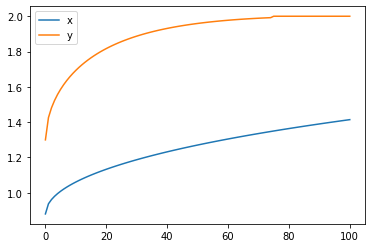

In [0]:
X, Y = [], []
for i in range(len(out)):
    z = pi * (out / cos)[:, i]
    z = z / z.max()

    def f(x, y, p_norm=2):
        if torch.is_tensor(x):
            x = x.double()
        if torch.is_tensor(y):
            y = y.double()
        ndim = max(getattr(e, 'ndim', 0) for e in (x, y))
        expand = tuple([...] + [None] * ndim)
        o = gpdf(m_s[:, i][expand], 0, x, y)
        o = o / o.max(0).values
        if p_norm is not None:
            return (z[expand] - o).norm(p_norm, dim=0)
        return o

    x, y = grid_search(f, (0.1, 2), (0.5, 2), density=100, eps=1e-6)
    X.append(x)
    Y.append(y)
plt.plot(X, label='x')  # [sqrt(pi) / 2, sqrt(2)]
plt.plot(Y, label='y')  # [1.3, 2]
plt.legend()
plt.show()

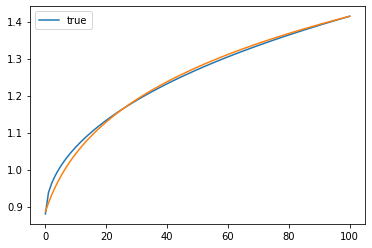

In [0]:
plt.plot(X, label='true')
# plt.plot(torch.linspace(sqrt(pi / 4)**e, sqrt(2)**e, 101)**(1 / e))
def std(x):
    e = 2 * pi
    x = (x + 1) / 2
    return (x * 2**(e / 2) + (1 - x) * (pi / 4)**(e / 2))**(1 / e)
    x = (1 / (x**(4 / pi) + 1)).acos()
    x = x / x.max()
    return x * (sqrt(2) - sqrt(pi) / 2) + sqrt(pi) / 2
plt.plot(std(torch.linspace(-1, 1, 101)))
plt.legend()
plt.show()

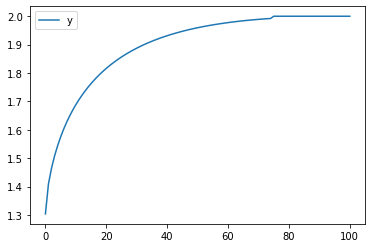

In [0]:
Y = []
for i in range(len(out)):
    z = pi * (out / cos)[:, i]
    z = z / z.max()

    def f(y, p_norm=2):
        if torch.is_tensor(y):
            y = y.double()
        ndim = getattr(y, 'ndim', 0)
        expand = tuple([...] + [None] * ndim)
        o = gpdf(m_s[:, i][expand], 0, std(rho[0, i]), y)
        o = o / o.max(0).values
        if p_norm is not None:
            return (z[expand] - o).norm(p_norm, dim=0)
        return o

    y, = grid_search(f, (0.5, 2), density=100, eps=1e-6)
    Y.append(y)
plt.plot(Y, label='y')  # [1.3, 2]
plt.legend()
plt.show()

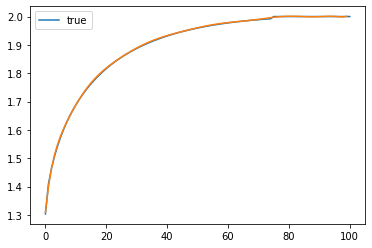

In [0]:
from numpy.polynomial import Polynomial

plt.plot(Y, label='true')
beta = Polynomial.fit(torch.linspace(-1, 1, 101), torch.tensor(Y), 13)
plt.plot(beta.linspace()[1])
plt.legend()
plt.show()

tensor(0.9783)


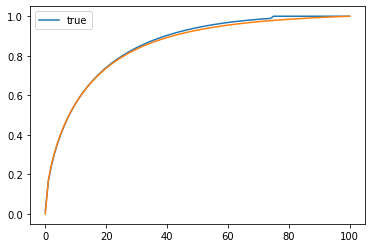

In [0]:
plt.plot((torch.tensor(Y) - 2) * sqrt(2) + 1, label='true')
def beta(x):
    x = (x + 1) / 2
    c = pi - sqrt(pi / 4)
    x = (c * x**(1 / sqrt(pi))).tanh()
    print(x.max())
    return x / x.max()
plt.plot(beta(torch.linspace(-1, 1, 101)))
plt.legend()
plt.show()

In [0]:
def beta(a, e=1 / sqrt(pi)):
    andim = getattr(a, 'ndim', 0)
    endim = getattr(e, 'ndim', 0)
    expand = tuple([...] + [None] * max(andim, endim))
    x = torch.linspace(-1, 1, 101)[expand]
    x = (x + 1) / 2
    x = (a * x**e).tanh()
    x = x / x.max(0).values
    y = (torch.tensor(Y) - 2) * sqrt(2) + 1
    return (x - y[expand]).norm(2, dim=0)
grid_search(beta, (1, 3))

(2.303256869316101,)

In [0]:
# n = m_s.shape[-1]
# std = torch.linspace(sqrt(pi) / 2, sqrt(2), n)
# beta = torch.linspace(sqrt(pi / 2), 2, n)
# pdf = gpdf(m_s, std=std, beta=beta)
# plot(pi * (out / cos))
# plot(pdf)

# Simple Exponential

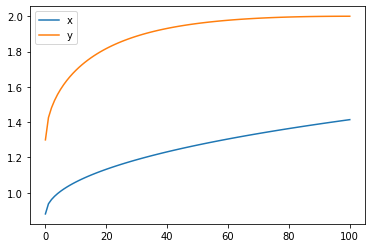

In [0]:
def dist(mean, std, beta):
    return exp(-abs(mean / std)**beta)

X, Y = [], []
t = pi * out / cos
for i in range(len(out)):
    def f(x, y, p_norm=2):
        if torch.is_tensor(x):
            x = x.double()
        if torch.is_tensor(y):
            y = y.double()
        ndim = max(getattr(e, 'ndim', 0) for e in (x, y))
        expand = tuple([...] + [None] * ndim)
        o = dist(m_s[:, i][expand], x, y)
        # o = o / o.max(0).values
        if p_norm is not None:
            return (t[:, i][expand] - o).norm(p_norm, dim=0)
        return o
    x, y = grid_search(f, (0.5, 2), (1, 3), density=10, eps=1e-6)
    Y.append(y)  # [1.3, 2]
    X.append(x)  # [sqrt(pi) / 2, sqrt(2)]
plt.plot(X, label='x')
plt.plot(Y, label='y')
plt.legend()
plt.show()
# o = dist(m_s, torch.tensor(X).view(1, -1), torch.tensor(Y).view(1, -1))
# plot(o - t)
# (o - t).abs().max().item()

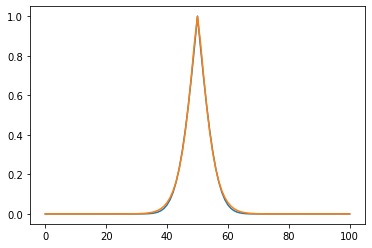

0.05319641950123395

In [0]:
#@title  { run: "auto", vertical-output: true }
i = 0 #@param {type:"slider", min:0, max:100, step:1}
z = pi * (out / cos)[:, i]
x = approximation(m_s, rho)[:, i]# dist(m_s[:, i], X[i], Y[i])

plt.plot(z)
plt.plot(x)
# plt.plot(z - x)
plt.show()
(z - x).norm(2, dim=0).item()

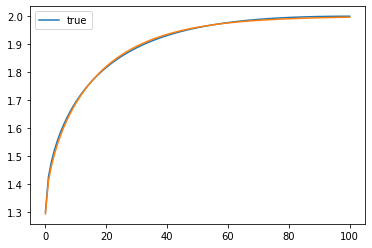

In [0]:
plt.plot(torch.tensor(Y), label='true')
def beta(x):
    x = (x + 1) / 2
    x = 2 * x**(1 / sqrt(pi))
    return x.erf() / sqrt(2) + (2 - sqrt(2) / 2)
plt.plot(beta(torch.linspace(-1, 1, 101)))
plt.legend()
plt.show()

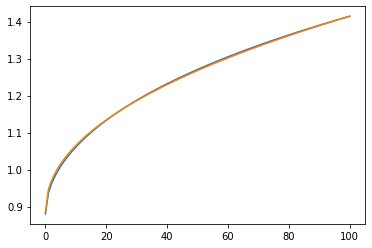

In [0]:
plt.plot(torch.tensor(X))
def std(x):
    x = (x + 1) / 2
    x = x**(1 / (2 / sqrt(pi) + 1))
    return x * (sqrt(2) - sqrt(pi) / 2) + sqrt(pi) / 2
plt.plot(std(torch.linspace(-1, 1, 101)))
plt.show()

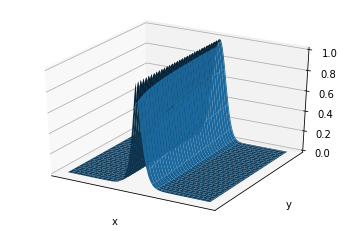

In [0]:
def approximation(m_s, rho):
    x = (rho + 1) / 2
    factor = sqrt(2) - sqrt(pi) / 2
    beta = (2 * s**(1 / sqrt(pi))).erf() * sqrt(1 / 2) + (2 - sqrt(2) / 2)
    std = s**(1 / (2 / sqrt(pi) + 1)) * factor + sqrt(pi) / 2
    return exp(-abs(m_s / std)**beta)

plot(approximation(m_s, rho))

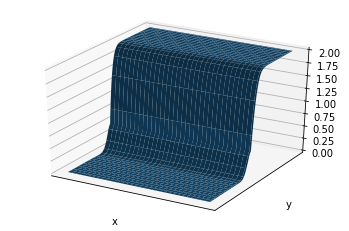

In [0]:
import torch
from math import sqrt, pi

def helper(mean_std, correlation):
    mean_std = mean_std[:, 0]
    x = (correlation + 1) / 2
    b = (2 * x**sqrt(1 / pi)).erf()
    b = b * sqrt(1 / 2) + (2 - sqrt(2) / 2)
    a = x**(1 / (2 / sqrt(pi) + 1))
    a = a * (sqrt(2) - sqrt(pi) / 2) + sqrt(pi) / 2
    out = (-mean_std.abs() / a).exp()**b
    cdf = 1 / 2 * (1 + (mean_std * sqrt(1 / 2)).erf())
    ooo = sqrt(pi) * cdf - sqrt(1 / pi) * correlation.acos() * out
    ooo = 1 / sqrt(pi) * ooo + cdf#[:, None]
    return ooo

lin = torch.linspace(-1, 1, 101)
z = helper(*torch.meshgrid(10 * lin, lin))
plot(z)
# plot(out)
# plot(z - out)